In [27]:
import os
import re
from matplotlib import pyplot as plt
import vrplib
def plot_CVRP_solution(routes, node_coords):
    plt.figure(figsize=(10, 8))

    # Plot nodes
    for i, (x, y) in enumerate(node_coords):
        plt.scatter(x, y, c='blue' if i == 0 else 'red')
        plt.text(x, y, f'{i}', fontsize=9, ha='right')
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    for vehicle, route in enumerate(routes):
        route_coords = [node_coords[node] for node in route]
        x_coords, y_coords = zip(*route_coords)
        plt.plot(x_coords, y_coords, c=colors[vehicle % len(colors)], label=f'Vehicle {vehicle + 1}')
    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Routing Problem Solution')
    plt.legend()
    plt.grid(True)
    plt.show()

def read_all_instances(root_folder, ending='.vrp'):
    instances = []
    for file_name in os.listdir(root_folder):
        if file_name.endswith(ending):
            instance = vrplib.read_instance(os.path.join(root_folder, file_name))
            if instance:
                instances.append(instance)
                print(f'Successfully read {file_name}')
            else:
                print(f'Failed to read {file_name}')
    return instances

def read_cvrp_data(file_name, ending='.vrp'):
    if file_name.endswith(ending):
        instance = vrplib.read_instance( file_name)
        if instance:
            print(f'Successfully read {file_name}')
        else:
            print(f'Failed to read {file_name}')
    data = {}
    # 基础参数设置
    data["vehicle_capacity"] = instance['capacity']
    data["num_vehicles"] = int(re.search(r'k(\d+)', instance['name']).group(1))
    data["depot"] = 0
    data['locations'] = [tuple(row) for row in instance['node_coord'].tolist()]
    data["num_locations"] = len(data["locations"])
    data['demand'] = instance['demand']
    data['distance_matrix']= instance['edge_weight']
    return data

question = read_cvrp_data('/Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n32-k5.vrp')
print(question)

Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n32-k5.vrp
{'vehicle_capacity': 100, 'num_vehicles': 5, 'depot': 0, 'locations': [(82, 76), (96, 44), (50, 5), (49, 8), (13, 7), (29, 89), (58, 30), (84, 39), (14, 24), (2, 39), (3, 82), (5, 10), (98, 52), (84, 25), (61, 59), (1, 65), (88, 51), (91, 2), (19, 32), (93, 3), (50, 93), (98, 14), (5, 42), (42, 9), (61, 62), (9, 97), (80, 55), (57, 69), (23, 15), (20, 70), (85, 60), (98, 5)], 'num_locations': 32, 'demand': array([ 0, 19, 21,  6, 19,  7, 12, 16,  6, 16,  8, 14, 21, 16,  3, 22, 18,
       19,  1, 24,  8, 12,  4,  8, 24, 24,  2, 20, 15,  2, 14,  9]), 'distance_matrix': array([[  0.        ,  34.92849839,  77.87810989, ...,  62.28964601,
         16.2788206 ,  72.78049189],
       [ 34.92849839,   0.        ,  60.30754513, ...,  80.32434251,
         19.41648784,  39.05124838],
       [ 77.87810989,  60.30754513,   0.        , ...,  71.58910532,
         65.19202405,  48.        ],
      

## V1

In [28]:
import itertools
import numpy as np

class FunSearch:
    def run(self, func):
        return func

    def evolve(self, func):
        return func
funsearch = FunSearch()

def solve(data):
    """Main CVRP solver using priority-based greedy heuristic"""
    num_vehicles = data['num_vehicles']
    depot = data['depot']
    demand = data['demand']
    capacity = data['vehicle_capacity']
    distance_matrix = data['distance_matrix']
    
    unvisited = set(range(len(distance_matrix))) - {depot}
    routes = [[] for _ in range(num_vehicles)]
    vehicle_loads = [0] * num_vehicles

    for vehicle_id in range(num_vehicles):
        current_node = depot
        current_route = [depot]
        current_load = 0

        while True:
            remaining_capacity = capacity - current_load
            candidates = [
                node for node in unvisited 
                if demand[node] <= remaining_capacity
            ]
            if not candidates:
                break

            # 使用进化优化的priority函数选择节点
            scores = [
                priority((current_node, node),  # 节点对作为元素
                distance_matrix[current_node][node],  # 作为n参数
                demand[node]  # 作为w参数
                ) for node in candidates
            ]
            next_node = candidates[scores.index(min(scores))]

            current_route.append(next_node)
            current_load += demand[next_node]
            unvisited.remove(next_node)
            current_node = next_node

        current_route.append(depot)
        routes[vehicle_id] = current_route
        vehicle_loads[vehicle_id] = current_load

    # 二次分配剩余节点（使用最小插入成本策略）
    while unvisited:
        node = unvisited.pop()
        best_cost = float('inf')
        best_vehicle = None
        
        for v_id in range(num_vehicles):
            if vehicle_loads[v_id] + demand[node] > capacity:
                continue
                
            # 计算最优插入位置
            for i in range(1, len(routes[v_id])):
                prev = routes[v_id][i-1]
                succ = routes[v_id][i]
                cost = (
                    distance_matrix[prev][node] +
                    distance_matrix[node][succ] -
                    distance_matrix[prev][succ]
                )
                if cost < best_cost:
                    best_cost = cost
                    best_vehicle = v_id
                    insert_pos = i
        
        if best_vehicle is not None:
            routes[best_vehicle].insert(insert_pos, node)
            vehicle_loads[best_vehicle] += demand[node]

    return routes

@funsearch.run
def evaluate(data) -> float:
    """评估解决方案并返回总行驶距离，同时输出详细路径信息"""
    routes = solve(data)
    total_distance = 0.0
    distance_matrix = data['distance_matrix']
    depot = data['depot']
    demand = data['demand']
    capacity = data['vehicle_capacity']
    
    # 计算总距离并验证解决方案
    for i, route in enumerate(routes):
        if len(route) < 2 or route[0] != depot or route[-1] != depot:
            raise ValueError(f"Invalid route {i}: {route} - must start and end at depot")
        
        route_distance = 0.0
        route_demand = 0
        for j in range(len(route)-1):
            from_node = route[j]
            to_node = route[j+1]
            route_distance += distance_matrix[from_node][to_node]
            if to_node != depot:  # 仓库需求为0
                route_demand += demand[to_node]
        
        if route_demand > capacity:
            raise ValueError(f"Route {i} overloaded: {route_demand}/{capacity}")
        
        total_distance += route_distance
        print(f"Vehicle {i} route: {route}")
        print(f"  Distance: {route_distance:.2f}, Load: {route_demand}/{capacity}")

    print(f"\nTotal distance: {total_distance:.2f}")
    print(f"Vehicles used: {sum(1 for r in routes if len(r) > 2)}/{len(routes)}")  # 排除空路线
    plot_CVRP_solution(routes, data['locations'])

    return total_distance

@funsearch.evolve
def priority(el: tuple[int, int], n: float, w: int) -> float:
    """Evolutionary priority scoring function (n=当前距离, w=需求)"""
    return n  # 基础公式：距离/需求

question = read_cvrp_data('A-n80-k10.vrp')
evaluate(question)

FileNotFoundError: [Errno 2] No such file or directory: 'A-n80-k10.vrp'

Successfully read A-n45-k6.vrp
Vehicle 0 route: [0, 1, 35, 14, 38, 31, 44, 0]
  Distance: 165.99, Load: 100/100
Vehicle 1 route: [0, 28, 7, 13, 20, 3, 10, 41, 0]
  Distance: 179.01, Load: 100/100
Vehicle 2 route: [0, 29, 43, 18, 17, 37, 0]
  Distance: 144.70, Load: 100/100
Vehicle 3 route: [0, 23, 15, 22, 16, 4, 42, 39, 2, 0]
  Distance: 196.08, Load: 99/100
Vehicle 4 route: [0, 6, 24, 27, 40, 30, 34, 19, 9, 0]
  Distance: 206.94, Load: 100/100
Vehicle 5 route: [0, 25, 12, 36, 8, 33, 21, 5, 32, 26, 11, 0]
  Distance: 352.89, Load: 94/100

Total distance: 1245.62
Vehicles used: 6/6


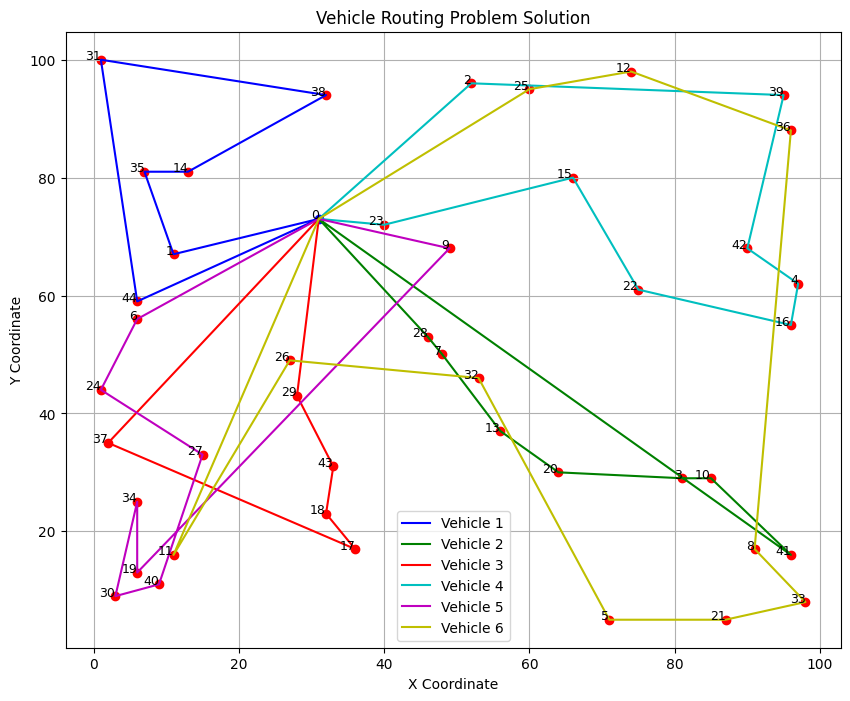

1245.6161593397176

In [34]:

@funsearch.evolve
def priority(el: tuple[int, int], n: float, w: int) -> float:
    """Evolutionary priority scoring function (n=当前距离, w=需求)"""
    return n / (w + 1e-6)  # 基础公式：距离/需求

question = read_cvrp_data('A-n45-k6.vrp')
evaluate(question)

Successfully read A-n45-k6.vrp
Vehicle 0 route: [0, 23, 28, 7, 32, 13, 20, 10, 42, 0]
  Distance: 178.66, Load: 100/100
Vehicle 1 route: [0, 1, 44, 6, 24, 37, 11, 19, 9, 0]
  Distance: 170.72, Load: 100/100
Vehicle 2 route: [0, 38, 14, 35, 31, 29, 26, 0]
  Distance: 163.46, Load: 99/100
Vehicle 3 route: [0, 15, 25, 2, 12, 36, 39, 4, 3, 41, 0]
  Distance: 287.29, Load: 98/100
Vehicle 4 route: [0, 43, 18, 17, 40, 30, 34, 0]
  Distance: 161.70, Load: 99/100
Vehicle 5 route: [0, 22, 16, 8, 33, 21, 5, 27, 0]
  Distance: 250.27, Load: 97/100

Total distance: 1212.10
Vehicles used: 6/6


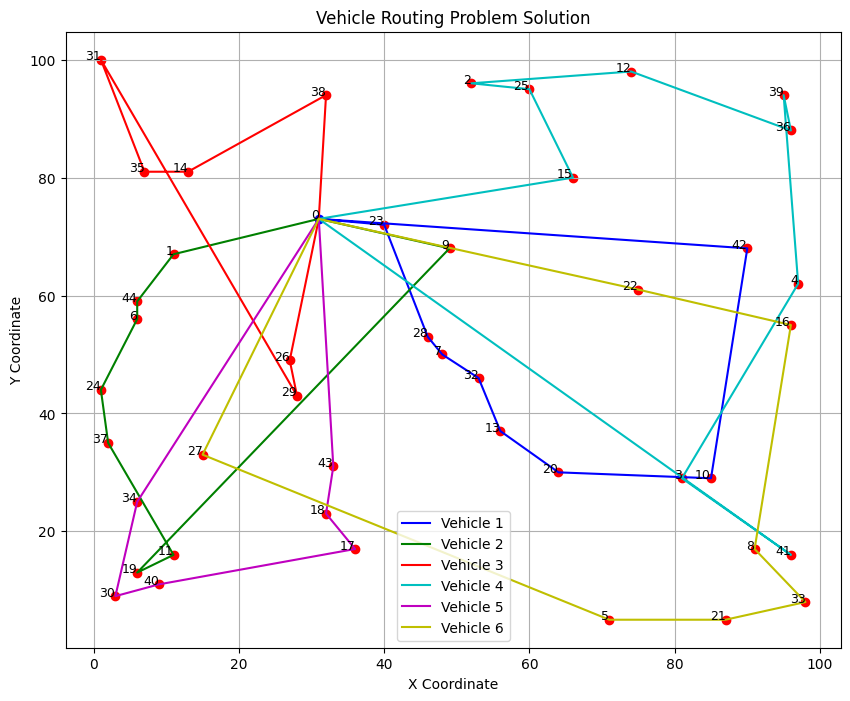

1212.0979675611209

In [37]:
@funsearch.evolve
def priority(el: tuple[int, int], n: float, w: int) -> float:
    """Evolutionary priority scoring function with parametric flexibility"""
    # 基础参数（通过演化自动调整）
    alpha = 0.1   # 距离权重系数 [0.5-1.5]
    beta = 0.7     # 需求调节系数 [0.2-0.8]
    gamma = 1.8    # 非线性因子 [0.5-2.0]
    
    # 动态调节项（基于需求特征）
    demand_term = (w ** beta) + 1e-6
    distance_term = (n ** gamma) 
    
    # 复合优先级公式
    base_priority = distance_term / demand_term
    
    # 非线性修正项
    correction = alpha * (n * w) ** 0.5
    
    return base_priority + correction

question = read_cvrp_data('A-n45-k6.vrp')
evaluate(question)

In [ ]:
from dataclasses import dataclass
from typing import Dict, Any

@dataclass
class RoutingContext:
    """路线规划上下文信息容器"""
    current_node: int
    candidate_node: int
    distance: float
    demand: int
    current_load: int
    remaining_capacity: int
    vehicle_id: int
    global_demand: tuple  # 元组形式保证可哈希
    capacity: int
    route_history: tuple   # 当前路径历史

def solve(data: Dict[str, Any]):
    # ...其他代码保持不变...
    
    for vehicle_id in range(num_vehicles):
        current_node = depot
        current_route = [depot]
        current_load = 0

        while True:
            remaining_capacity = capacity - current_load
            candidates = [node for node in unvisited if demand[node] <= remaining_capacity]
            if not candidates:
                break

            # 构建完整的上下文信息
            contexts = [
                RoutingContext(
                    current_node=current_node,
                    candidate_node=node,
                    distance=distance_matrix[current_node][node],
                    demand=demand[node],
                    current_load=current_load,
                    remaining_capacity=remaining_capacity,
                    vehicle_id=vehicle_id,
                    global_demand=tuple(demand),  # 转换为元组保证可哈希
                    capacity=capacity,
                    route_history=tuple(current_route)
                ) for node in candidates
            ]

            # 使用带完整上下文的优先级计算
            scores = [priority(ctx) for ctx in contexts]
            next_node = candidates[scores.index(min(scores))]
            
            # ...后续操作保持不变...

@funsearch.evolve
def priority(ctx: RoutingContext) -> float:
    """可演化的优先级计算函数"""
    # 基础参数（通过演化调整）
    alpha = 0.85
    beta = 1.2
    gamma = 0.3
    
    # 复合计算公式
    distance_term = ctx.distance ** beta
    demand_term = (ctx.demand + 1e-6) ** alpha
    load_factor = (ctx.capacity - ctx.remaining_capacity) / ctx.capacity
    
    # 动态权重调整
    return (distance_term / demand_term) * (1 + gamma * load_factor)

In [2]:

SYSTEM_PROMPT="""
You are a state-of-the-art Python code completion system.
Your primary task is to solve the Capacitated Vehicle Routing Problem (CVRP) and provide the optimal solution as much as possible.
You will be provided with a list of functions, and your job is to improve the code. 
1. Observe the patterns in the dataset and adjust the code according to the data characteristics.
2. Keep the code concise and comments brief.
3. You may use the numpy and itertools libraries.
The code you generate will be appended to the user prompt and run as a Python program.
"""

USER_PROMPT = """
Find the better CVRP solution, try to change @funsearch.evolve:  construction_heuristic
just only change and reture tihis function's mame
only return the implementation of  @funsearch.evolve: construction_heuristic
please sure your is correct python code and just provide function ` construction_heuristic_v# (where # is the current iteration number); do not include any examples or extraneous functions.

Here is the code template, dataset as follows\n
IMPORTANT: Your response should only involve the function  `construction_heuristic_v#`, don't give other code.
"""

CODE_TEMPLATE = """
import numpy as np
from dataclasses import dataclass
from typing import Tuple, List

class FunSearch:
    def run(self, func): return func
    def evolve(self, func): return func
funsearch = FunSearch()

@dataclass
class ConstructionContext:
    depot: int
    candidate: int
    distance: float
    demand: int
    vehicle_load: int
    vehicle_capacity: int
    locations: np.ndarray

@dataclass
class LocalSearchContext:
    route: Tuple[int, ...]
    candidate_nodes: Tuple[int, ...]
    distance_matrix: np.ndarray
    demand: np.ndarray
    capacity: int

def solve(data: dict) -> List[List[int]]:
    #两阶段求解框架
    # 阶段1：启发式初始解构建
    initial_routes = greedy_initial_solution(data)
    
    # 阶段2：进化局部优化
    optimized_routes = local_search_optimization(data, initial_routes)
    
    return optimized_routes

# ========== 初始解构建阶段 ==========
@funsearch.evolve
def construction_heuristic(ctx: ConstructionContext) -> float:
    #进化初始解构建策略（可调整权重)
    # part1: you should change and modify this function
    return (1 * ctx.distance )

def greedy_initial_solution(data: dict) -> List[List[int]]:
    #基于进化权重的启发式初始解生成
    routes = []
    unvisited = set(range(len(data['demand']))) - {data['depot']}
    
    while unvisited and len(routes) < data['num_vehicles']:
        # part2: you should change and modify this function
        route = [data['depot']]
        current_load = 0
        
        while True:
            candidates = [n for n in unvisited 
                         if data['demand'][n] + current_load <= data['vehicle_capacity']]
            if not candidates: break
            
            # 生成候选上下文
            contexts = [
                ConstructionContext(
                    depot=data['depot'],
                    candidate=n,
                    distance=data['distance_matrix'][route[-1]][n],
                    demand=data['demand'][n],
                    vehicle_load=current_load,
                    vehicle_capacity=data['vehicle_capacity'],
                    locations=data['locations']
                ) for n in candidates
            ]
            
            # 选择最优候选节点
            scores = [construction_heuristic(ctx) for ctx in contexts]
            next_node = candidates[np.argmin(scores)]
            
            route.append(next_node)
            current_load += data['demand'][next_node]
            unvisited.remove(next_node)
        
        route.append(data['depot'])
        routes.append(route)
    
    return routes

# ========== 局部优化阶段 ==========
@funsearch.evolve
def local_search_optimization(data: dict, routes: List[List[int]]) -> List[List[int]]:
    #基于进化策略的局部搜索
    optimized = []
    for route in routes:
        if len(route) <= 2:
            optimized.append(route)
            continue

        # 生成优化上下文
        ctx = LocalSearchContext(
            route=tuple(route),
            candidate_nodes=tuple(data['demand'].nonzero()[0]),
            distance_matrix=data['distance_matrix'],
            demand=data['demand'],
            capacity=data['vehicle_capacity']
        )

        # 应用进化优化策略
        while True:
            original_cost = sum(ctx.distance_matrix[i][j] for i, j in zip(ctx.route[:-1], ctx.route[1:]))
            best_improvement = 0.0
            best_route = route.copy()

            # 2-opt邻域评估
            for i in range(1, len(ctx.route) - 2):
                for j in range(i + 1, len(ctx.route) - 1):
                    new_cost = original_cost - ctx.distance_matrix[ctx.route[i - 1]][ctx.route[i]] \
                               - ctx.distance_matrix[ctx.route[j]][ctx.route[j + 1]] \
                               + ctx.distance_matrix[ctx.route[i - 1]][ctx.route[j]] \
                               + ctx.distance_matrix[ctx.route[i]][ctx.route[j + 1]]
                    improvement = original_cost - new_cost
                    if improvement > best_improvement:
                        best_improvement = improvement
                        new_route = list(ctx.route)
                        new_route[i:j + 1] = reversed(new_route[i:j + 1])
                        best_route = new_route

            if best_improvement <= 0:
                break
            route = best_route
            ctx.route = tuple(route)

        optimized.append(route)

    return optimized

@funsearch.run
def evaluate(data):
    routes = solve(data)
    total_distance = 0.0
    distance_matrix = data['distance_matrix']
    depot = data['depot']
    demand = data['demand']
    capacity = data['vehicle_capacity']
    
    #评估解决方案并返回状态和总行驶距离
    try:
        for i, route in enumerate(routes):
            if len(route) < 2 or route[0] != depot or route[-1] != depot:
                raise ValueError(f"Invalid route {i}: {route} - must start and end at depot")

            route_distance = 0.0
            route_demand = 0
            for j in range(len(route) - 1):
                from_node = route[j]
                to_node = route[j + 1]
                route_distance += distance_matrix[from_node][to_node]
                if to_node != depot:  # 仓库需求为0
                    route_demand += demand[to_node]

            if route_demand > capacity:
                raise ValueError(f"Route {i} overloaded: {route_demand}/{capacity}")

            total_distance += route_distance

        return "success", total_distance,
    except ValueError as e:
        print(f"Evaluation failed: {e}")
        return "fail", "",[]
"""


In [ ]:

import ast
import astunparse
from openai import OpenAI
import re

client = OpenAI(api_key="", base_url="https://api.deepseek.com")


# 修剪 LLM 生成的代码，确保只包含函数体
def md_to_source_code(md_text):
    # 定义正则表达式模式来匹配 Python 代码块
    pattern = re.compile(r'```python(.*?)```', re.DOTALL)
    match = pattern.search(md_text)
    if match:
        # 提取代码块内容并去除首尾空格
        return match.group(1).strip()
    return None

def _trim_function_body(generated_code: str, generated_func_name: str) -> str:
    """
    解析 LLM 生成的代码，确保只提取函数体。
    """
    code=md_to_source_code(generated_code)
    try:
        module = ast.parse(code)  # 解析 AST
        return "\n".join(code.split("\n"))  # 仅保留函数体
    except():
        KeyError
        


response = client.chat.completions.create(
    model="deepseek-chat",
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": USER_PROMPT+CODE_TEMPLATE},
    ],
    stream=False
)
func_name = 'construction_heuristic'
generated_func = _trim_function_body(response.choices[0].message.content,func_name)



TypeError: replace_function_by_name() got an unexpected keyword argument 'generated_func'

In [12]:

def replace_function_by_name(source_code, old_function_name, new_function_str):
    # 解析源代码为抽象语法树
    tree = ast.parse(source_code)
    new_function_ast =  ast.parse(new_function_str)
    # 定义一个访问者类，用于遍历抽象语法树
    class FunctionReplacer(ast.NodeTransformer):
        def visit_FunctionDef(self, node):
            # 如果当前节点是函数定义，并且函数名与要替换的函数名相同
            if node.name == old_function_name:
                # 返回新的函数定义节点来替换原节点
                return new_function_ast
            # 否则保留该节点
            return self.generic_visit(node)

    # 创建访问者实例
    replacer = FunctionReplacer()
    # 对抽象语法树进行转换
    new_tree = replacer.visit(tree)

    # 将修改后的抽象语法树转换回 Python 代码
    new_code = ast.unparse(new_tree)
    return new_code
new_code = replace_function_by_name(CODE_TEMPLATE,func_name, generated_func)
print(new_code)

import numpy as np
from dataclasses import dataclass
from typing import Tuple, List

class FunSearch:

    def run(self, func):
        return func

    def evolve(self, func):
        return func
funsearch = FunSearch()

@dataclass
class ConstructionContext:
    depot: int
    candidate: int
    distance: float
    demand: int
    vehicle_load: int
    vehicle_capacity: int
    locations: np.ndarray

@dataclass
class LocalSearchContext:
    route: Tuple[int, ...]
    candidate_nodes: Tuple[int, ...]
    distance_matrix: np.ndarray
    demand: np.ndarray
    capacity: int

def solve(data: dict) -> List[List[int]]:
    initial_routes = greedy_initial_solution(data)
    optimized_routes = local_search_optimization(data, initial_routes)
    return optimized_routes

@funsearch.evolve
def construction_heuristic_v1(ctx: ConstructionContext) -> float:
    distance_weight = 1.0
    capacity_weight = 0.5
    normalized_distance = ctx.distance / np.max(ctx.distance_matrix)
    capacity_utilizati

In [ ]:

import ast


text=response.choices[0].message.content

def _trim_function_body(generated_code: str) -> str:
    """
    解析 LLM 生成的代码，确保只提取函数体。
    """
    code=md_to_source_code(generated_code)
    module = ast.parse(code)  # 解析 AST
    for node in module.body:
        if isinstance(node, ast.FunctionDef) and node.name == "construction_heuristic_v1":
            end_lineno = node.end_lineno  # 获取函数体的结束行号
            break
    return "\n".join(code.split("\n")[:end_lineno - 1])  # 仅保留函数体

def md_to_source_code(md_text):
    # 定义正则表达式模式来匹配 Python 代码块
    pattern = re.compile(r'```python(.*?)```', re.DOTALL)
    match = pattern.search(md_text)
    if match:
        # 提取代码块内容并去除首尾空格
        return match.group(1).strip()
    return None

md_to_source_code(text)
res=_trim_function_body(text)
print(res)

@funsearch.evolve
def construction_heuristic_v1(ctx: ConstructionContext) -> float:
    # Enhanced heuristic considering both distance and capacity utilization
    distance_weight = 1.0
    utilization_weight = 0.5  # Balances distance and capacity utilization
    
    # Normalize distance and utilization
    normalized_distance = ctx.distance / np.max(ctx.distance_matrix)
    normalized_utilization = (ctx.vehicle_load + ctx.demand) / ctx.vehicle_capacity
    
    return (distance_weight * normalized_distance 


In [ ]:
import numpy as np
from dataclasses import dataclass
from typing import Tuple, List

class FunSearch:
    def run(self, func):
        return func

    def evolve(self, func):
        return func
funsearch = FunSearch()

@dataclass
class RoutingContext:
    current_node: int
    candidate_node: int
    distance: float
    demand: int
    current_load: int
    remaining_capacity: int
    vehicle_id: int
    global_demand: Tuple[int, ...]
    capacity: int
    route_history: Tuple[int, ...]
    all_routes: Tuple[Tuple[int, ...], ...]
    distance_matrix: np.ndarray
    depot: int
    locations: np.ndarray

def solve(data: dict) -> List[List[int]]:
    """基于完整上下文的进化车辆路径规划"""
    # 初始化基础参数
    num_vehicles = data['num_vehicles']
    depot = data['depot']
    demand = data['demand']
    capacity = data['vehicle_capacity']
    distance_matrix = data['distance_matrix']
    locations = data.get('locations', np.zeros((len(demand), 2)))
    
    unvisited = set(range(len(distance_matrix))) - {depot}
    routes = [[] for _ in range(num_vehicles)]
    vehicle_loads = [0] * num_vehicles

    # 第一阶段：上下文感知路径构建
    for vid in range(num_vehicles):
        current_node = depot
        current_route = [depot]
        current_load = 0
        
        while True:
            remaining_cap = capacity - current_load
            candidates = [n for n in unvisited if demand[n] <= remaining_cap]
            if not candidates:
                break
            
            # 生成候选上下文
            frozen_routes = tuple(tuple(r) for r in routes)
            contexts = []
            for node in candidates:
                ctx = RoutingContext(
                    current_node=current_node,
                    candidate_node=node,
                    distance=distance_matrix[current_node][node],
                    demand=demand[node],
                    current_load=current_load,
                    remaining_capacity=remaining_cap,
                    vehicle_id=vid,
                    global_demand=tuple(demand),
                    capacity=capacity,
                    route_history=tuple(current_route),
                    all_routes=frozen_routes,
                    distance_matrix=distance_matrix,
                    depot=depot,
                    locations=locations
                )
                contexts.append(ctx)
            
            # 获取进化优先级评分
            scores = [priority(ctx) for ctx in contexts]
            next_node = candidates[np.argmin(scores)]
            
            # 更新状态
            current_route.append(next_node)
            current_load += demand[next_node]
            unvisited.remove(next_node)
            current_node = next_node
        
        # 完成当前车辆路径
        current_route.append(depot)
        routes[vid] = current_route
        vehicle_loads[vid] = current_load

    # 第二阶段：剩余节点插入
    while unvisited:
        node = unvisited.pop()
        best_cost = np.inf
        best_insert = (None, None)
        
        for vid in range(num_vehicles):
            if vehicle_loads[vid] + demand[node] > capacity:
                continue
                
            # 生成插入上下文
            frozen_routes = tuple(tuple(r) for r in routes)
            for i in range(1, len(routes[vid])):
                prev = routes[vid][i-1]
                succ = routes[vid][i]
                ctx = RoutingContext(
                    current_node=prev,
                    candidate_node=node,
                    distance=distance_matrix[prev][node] + distance_matrix[node][succ],
                    demand=demand[node],
                    current_load=vehicle_loads[vid],
                    remaining_capacity=capacity - vehicle_loads[vid],
                    vehicle_id=vid,
                    global_demand=tuple(demand),
                    capacity=capacity,
                    route_history=tuple(routes[vid]),
                    all_routes=frozen_routes,
                    distance_matrix=distance_matrix,
                    depot=depot,
                    locations=locations
                )
                
                # 计算插入成本
                insertion_cost = priority(ctx)
                if insertion_cost < best_cost:
                    best_cost = insertion_cost
                    best_insert = (vid, i)
        
        # 执行最优插入
        if best_insert[0] is not None:
            vid, pos = best_insert
            routes[vid].insert(pos, node)
            vehicle_loads[vid] += demand[node]

    return routes

@funsearch.run
def evaluate(data: dict) -> float:
    """解决方案评估与验证"""
    routes = solve(data)
    total_distance = 0.0
    distance_matrix = data['distance_matrix']
    capacity = data['vehicle_capacity']
    depot = data['depot']
    
    for route in routes:
        # 验证路径格式
        if len(route) < 2 or route[0] != depot or route[-1] != depot:
            return np.inf
        
        # 计算路径距离
        route_dist = sum(distance_matrix[i][j] for i,j in zip(route[:-1], route[1:]))
        total_distance += route_dist
        
        # 验证负载约束
        route_demand = sum(data['demand'][n] for n in route if n != depot)
        if route_demand > capacity:
            return np.inf
    
    return total_distance

@funsearch.evolve
def priority(ctx: RoutingContext) -> float:
    """进化优化的多目标评分函数"""
    # 基础距离成本
    distance_term = ctx.distance
    
    # 需求效率因子
    demand_factor = 1 / (ctx.demand + 1e-6)
    
    # 容量利用率
    capacity_usage = (ctx.capacity - ctx.remaining_capacity) / ctx.capacity
    
    # 地理聚类因子
    if len(ctx.route_history) > 2:
        valid_nodes = [n for n in ctx.route_history if n != ctx.depot]
        centroid = np.mean([ctx.locations[n] for n in valid_nodes], axis=0)
        candidate_loc = ctx.locations[ctx.candidate_node]
        cluster_dist = np.linalg.norm(candidate_loc - centroid)
    else:
        cluster_dist = 0
    
    # 负载均衡因子
    global_loads = [
        sum(ctx.global_demand[n] for n in route if n != ctx.depot)
        for route in ctx.all_routes
    ]
    load_balance = np.std(global_loads) if len(global_loads) > 0 else 0
    
    # 动态权重系数
    return (
        0.5 * distance_term +
        0.1 * demand_factor +
        0.1 * capacity_usage +
        9.3 * cluster_dist +
        2.8 * load_balance
    )
question = read_cvrp_data('A-n44-k6.vrp')
evaluate(question)

Successfully read A-n44-k6.vrp


1262.2904593425276

In [25]:
@funsearch.evolve
def priority(ctx: RoutingContext) -> float:
    """动态自适应评分函数"""
        
    # 基础距离项（标准化处理）
    normalized_dist = ctx.distance / np.percentile(ctx.distance_matrix, 75)
    
    # 需求效率项（鼓励服务高需求节点）
    demand_efficiency = (ctx.demand / 24) ** 0.8  # 24为最大需求
    
    # 容量压力项（动态调整权重）
    load_ratio = ctx.current_load / ctx.capacity
    capacity_pressure = np.clip(1.5 ** (10 * (load_ratio - 0.7)), 0, 5)
    
    # 地理聚类项（自适应调整）
    cluster_weight = 0.2 if len(ctx.route_history) < 5 else 0.05
    if len(ctx.route_history) > 2:
        valid_nodes = [n for n in ctx.route_history if n != ctx.depot]
        centroid = np.mean([ctx.locations[n] for n in valid_nodes], axis=0)
        candidate_loc = ctx.locations[ctx.candidate_node]
        cluster_dist = np.linalg.norm(candidate_loc - centroid) / 100  # 标准化
    else:
        cluster_dist = 0
    # 区域平衡项（防止边缘节点集中）
    depot_loc = ctx.locations[ctx.depot]
    candidate_node_arr = np.array(ctx.locations[ctx.candidate_node])
    # 假设depot_loc是元组，先转换为数组
    depot_loc_arr = np.array(depot_loc)
    candidate_depot_dist = np.linalg.norm(candidate_node_arr - depot_loc_arr)

    region_balance = 0.1 * (candidate_depot_dist / 140)  # 140为最大欧氏距离
    
    # 动态组合权重
    return (
        0.55 * normalized_dist 
        - 0.25 * demand_efficiency 
        + 0.15 * capacity_pressure 
        + cluster_weight * cluster_dist 
        + region_balance
    )
    
question = read_cvrp_data('A-n45-k6.vrp')
evaluate(question)

NameError: name 'RoutingContext' is not defined

In [14]:
import numpy as np
import os
from dataclasses import dataclass
from typing import Tuple, List

class FunSearch:
    def run(self, func): return func
    def evolve(self, func): return func
funsearch = FunSearch()

@dataclass
class ConstructionContext:
    depot: int
    candidate: int
    distance: float
    demand: int
    vehicle_load: int
    vehicle_capacity: int
    locations: np.ndarray

@dataclass
class LocalSearchContext:
    route: Tuple[int, ...]
    candidate_nodes: Tuple[int, ...]
    distance_matrix: np.ndarray
    demand: np.ndarray
    capacity: int

def solve(data: dict) -> List[List[int]]:
    """两阶段求解框架"""
    # 阶段1：启发式初始解构建
    initial_routes = greedy_initial_solution(data)
    
    # 阶段2：进化局部优化
    optimized_routes = local_search_optimization(data, initial_routes)
    
    return optimized_routes

# ========== 初始解构建阶段 ==========
@funsearch.evolve
def construction_heuristic(ctx: ConstructionContext) -> float:
    """进化初始解构建策略（可调整权重）"""
    # part1: you should change and modify this function
    return (1 * ctx.distance )

def greedy_initial_solution(data: dict) -> List[List[int]]:
    """基于进化权重的启发式初始解生成"""
    routes = []
    unvisited = set(range(len(data['demand']))) - {data['depot']}
    
    while unvisited and len(routes) < data['num_vehicles']:
        # part2: you should change and modify this function
        route = [data['depot']]
        current_load = 0
        
        while True:
            candidates = [n for n in unvisited 
                         if data['demand'][n] + current_load <= data['vehicle_capacity']]
            if not candidates: break
            
            # 生成候选上下文
            contexts = [
                ConstructionContext(
                    depot=data['depot'],
                    candidate=n,
                    distance=data['distance_matrix'][route[-1]][n],
                    demand=data['demand'][n],
                    vehicle_load=current_load,
                    vehicle_capacity=data['vehicle_capacity'],
                    locations=data['locations']
                ) for n in candidates
            ]
            
            # 选择最优候选节点
            scores = [construction_heuristic(ctx) for ctx in contexts]
            next_node = candidates[np.argmin(scores)]
            
            route.append(next_node)
            current_load += data['demand'][next_node]
            unvisited.remove(next_node)
        
        route.append(data['depot'])
        routes.append(route)
    
    return routes

# ========== 局部优化阶段 ==========
@funsearch.evolve
def local_search_optimization(data: dict, routes: List[List[int]]) -> List[List[int]]:
    """基于进化策略的局部搜索"""
    optimized = []
    for route in routes:
        if len(route) <= 2:
            optimized.append(route)
            continue

        # 生成优化上下文
        ctx = LocalSearchContext(
            route=tuple(route),
            candidate_nodes=tuple(data['demand'].nonzero()[0]),
            distance_matrix=data['distance_matrix'],
            demand=data['demand'],
            capacity=data['vehicle_capacity']
        )

        # 应用进化优化策略
        while True:
            original_cost = sum(ctx.distance_matrix[i][j] for i, j in zip(ctx.route[:-1], ctx.route[1:]))
            best_improvement = 0.0
            best_route = route.copy()

            # 2-opt邻域评估
            for i in range(1, len(ctx.route) - 2):
                for j in range(i + 1, len(ctx.route) - 1):
                    new_cost = original_cost - ctx.distance_matrix[ctx.route[i - 1]][ctx.route[i]] \
                               - ctx.distance_matrix[ctx.route[j]][ctx.route[j + 1]] \
                               + ctx.distance_matrix[ctx.route[i - 1]][ctx.route[j]] \
                               + ctx.distance_matrix[ctx.route[i]][ctx.route[j + 1]]
                    improvement = original_cost - new_cost
                    if improvement > best_improvement:
                        best_improvement = improvement
                        new_route = list(ctx.route)
                        new_route[i:j + 1] = reversed(new_route[i:j + 1])
                        best_route = new_route

            if best_improvement <= 0:
                break
            route = best_route
            ctx.route = tuple(route)

        optimized.append(route)

    return optimized

@funsearch.run
def evaluate(data: dict) -> float:
    """统一评估接口"""
    routes = solve(data)
    return total_distance(routes, data['distance_matrix'])

def calculate_route_distance(route: List[int], distance_matrix) -> float:
    """
    计算给定路径的总距离
    :param route: 路径节点列表
    :param distance_matrix: 距离矩阵
    :return: 路径总距离
    """
    distance = 0
    for i in range(len(route) - 1):
        distance += distance_matrix[route[i]][route[i + 1]]
    # 如果是回路，回到起点
    if len(route) > 0:
        distance += distance_matrix[route[-1]][route[0]]
    return distance

def total_distance(routes: List[List[int]], matrix: np.ndarray) -> float:
    return sum(matrix[i][j] for route in routes for i,j in zip(route[:-1], route[1:]))

question = read_cvrp_data('A-n45-k6.vrp')
evaluate(question)

NameError: name 'read_cvrp_data' is not defined

In [5]:

import numpy as np
import re
from dataclasses import dataclass
from typing import Tuple, List
import vrplib

class FunSearch:
    def run(self, func): return func
    def evolve(self, func): return func
funsearch = FunSearch()

@dataclass
class ConstructionContext:
    depot: int
    candidate: int
    distance: float
    demand: int
    vehicle_load: int
    vehicle_capacity: int
    locations: np.ndarray

@dataclass
class LocalSearchContext:
    route: Tuple[int, ...]
    candidate_nodes: Tuple[int, ...]
    distance_matrix: np.ndarray
    demand: np.ndarray
    capacity: int

def solve(data: dict) -> List[List[int]]:
    #两阶段求解框架
    # 阶段1：启发式初始解构建
    initial_routes = greedy_initial_solution(data)
    
    # 阶段2：进化局部优化
    optimized_routes = local_search_optimization(data, initial_routes)
    
    return optimized_routes

# ========== 初始解构建阶段 ==========
@funsearch.evolve
def construction_heuristic(ctx: ConstructionContext) -> float:
    #进化初始解构建策略（可调整权重)
    # part1: you should change and modify this function
    return (1 * ctx.distance )

def greedy_initial_solution(data: dict) -> List[List[int]]:
    #基于进化权重的启发式初始解生成
    routes = []
    unvisited = set(range(len(data['demand']))) - {data['depot']}
    
    while unvisited and len(routes) < data['num_vehicles']:
        # part2: you should change and modify this function
        route = [data['depot']]
        current_load = 0
        
        while True:
            candidates = [n for n in unvisited 
                         if data['demand'][n] + current_load <= data['vehicle_capacity']]
            if not candidates: break
            
            # 生成候选上下文
            contexts = [
                ConstructionContext(
                    depot=data['depot'],
                    candidate=n,
                    distance=data['distance_matrix'][route[-1]][n],
                    demand=data['demand'][n],
                    vehicle_load=current_load,
                    vehicle_capacity=data['vehicle_capacity'],
                    locations=data['locations']
                ) for n in candidates
            ]
            
            # 选择最优候选节点
            scores = [construction_heuristic(ctx) for ctx in contexts]
            next_node = candidates[np.argmin(scores)]
            
            route.append(next_node)
            current_load += data['demand'][next_node]
            unvisited.remove(next_node)
        
        route.append(data['depot'])
        routes.append(route)
    
    return routes

# ========== 局部优化阶段 ==========
@funsearch.evolve
def local_search_optimization(data: dict, routes: List[List[int]]) -> List[List[int]]:
    #基于进化策略的局部搜索
    optimized = []
    for route in routes:
        if len(route) <= 2:
            optimized.append(route)
            continue

        # 生成优化上下文
        ctx = LocalSearchContext(
            route=tuple(route),
            candidate_nodes=tuple(data['demand'].nonzero()[0]),
            distance_matrix=data['distance_matrix'],
            demand=data['demand'],
            capacity=data['vehicle_capacity']
        )

        # 应用进化优化策略
        while True:
            original_cost = sum(ctx.distance_matrix[i][j] for i, j in zip(ctx.route[:-1], ctx.route[1:]))
            best_improvement = 0.0
            best_route = route.copy()

            # 2-opt邻域评估
            for i in range(1, len(ctx.route) - 2):
                for j in range(i + 1, len(ctx.route) - 1):
                    new_cost = original_cost - ctx.distance_matrix[ctx.route[i - 1]][ctx.route[i]] \
                               - ctx.distance_matrix[ctx.route[j]][ctx.route[j + 1]] \
                               + ctx.distance_matrix[ctx.route[i - 1]][ctx.route[j]] \
                               + ctx.distance_matrix[ctx.route[i]][ctx.route[j + 1]]
                    improvement = original_cost - new_cost
                    if improvement > best_improvement:
                        best_improvement = improvement
                        new_route = list(ctx.route)
                        new_route[i:j + 1] = reversed(new_route[i:j + 1])
                        best_route = new_route

            if best_improvement <= 0:
                break
            route = best_route
            ctx.route = tuple(route)

        optimized.append(route)

    return optimized

@funsearch.run
def evaluate(data):
    routes = solve(data)
    total_distance = 0.0
    distance_matrix = data['distance_matrix']
    depot = data['depot']
    demand = data['demand']
    capacity = data['vehicle_capacity']
    
    #评估解决方案并返回状态和总行驶距离
    try:
        for i, route in enumerate(routes):
            if len(route) < 2 or route[0] != depot or route[-1] != depot:
                raise ValueError(f"Invalid route {i}: {route} - must start and end at depot")

            route_distance = 0.0
            route_demand = 0
            for j in range(len(route) - 1):
                from_node = route[j]
                to_node = route[j + 1]
                route_distance += distance_matrix[from_node][to_node]
                if to_node != depot:  # 仓库需求为0
                    route_demand += demand[to_node]

            if route_demand > capacity:
                raise ValueError(f"Route {i} overloaded: {route_demand}/{capacity}")

            total_distance += route_distance

        return "success", total_distance,
    except ValueError as e:
        print(f"Evaluation failed: {e}")
        return "fail", "",[]
    
def read_all_instances(root_folder, ending='.vrp'):
    instances = {}
    for file_name in os.listdir(root_folder):
        if file_name.endswith(ending):
            instance = read_cvrp_data(os.path.join(root_folder, file_name))
            if instance:
                instances[file_name] = instance
                print(f'Successfully read {file_name}')
            else:
                print(f'Failed to read {file_name}')
    return instances

def read_cvrp_data(file_name, ending='.vrp'):
    if file_name.endswith(ending):
        instance = vrplib.read_instance( file_name)
        if instance:
            print(f'Successfully read {file_name}')
        else:
            print(f'Failed to read {file_name}')
    data = {}
    # 基础参数设置
    data["vehicle_capacity"] = instance['capacity']
    data["num_vehicles"] = int(re.search(r'k(\d+)', instance['name']).group(1))
    data["depot"] = 0
    data['locations'] = [tuple(row) for row in instance['node_coord'].tolist()]
    data["num_locations"] = len(data["locations"])
    data['demand'] = instance['demand']
    data['distance_matrix']= instance['edge_weight']
    return data

# evaluate(data)
instances = read_all_instances('/Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small')
data = instances['A-n32-k5.vrp']
print(data)
evaluate(data)

Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n37-k5.vrp
Successfully read A-n37-k5.vrp
Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n44-k6.vrp
Successfully read A-n44-k6.vrp
Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n48-k7.vrp
Successfully read A-n48-k7.vrp
Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/P-n50-k10.vrp
Successfully read P-n50-k10.vrp
Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n32-k5.vrp
Successfully read A-n32-k5.vrp
Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n45-k6.vrp
Successfully read A-n45-k6.vrp
{'vehicle_capacity': 100, 'num_vehicles': 5, 'depot': 0, 'locations': [(82, 76), (96, 44), (50, 5), (49, 8), (13, 7), (29, 89), (58, 30), (84, 39), (14, 24), (2, 39), (3, 82), (5, 10), (98, 52),

('success', 1118.2647889064563)

In [12]:
import numpy as np
import re
from dataclasses import dataclass
from typing import Tuple, List
import vrplib
class FunSearch:
    def run(self, func): return func
    def evolve(self, func): return func
funsearch = FunSearch()

@dataclass
class ConstructionContext:
    depot: int
    candidate: int
    distance: float
    demand: int
    vehicle_load: int
    vehicle_capacity: int
    locations: np.ndarray

@dataclass
class LocalSearchContext:
    route: Tuple[int, ...]
    candidate_nodes: Tuple[int, ...]
    distance_matrix: np.ndarray
    demand: np.ndarray
    capacity: int

def solve(data: dict) -> List[List[int]]:
    #两阶段求解框架
    # 阶段1：启发式初始解构建
    initial_routes = greedy_initial_solution(data)
    
    # 阶段2：进化局部优化
    optimized_routes = local_search_optimization(data, initial_routes)
    
    return optimized_routes

# ========== 初始解构建阶段 ==========


@funsearch.evolve
def construction_heuristic(ctx: ConstructionContext) -> float:
    # Improved heuristic considering both distance and remaining capacity utilization
    distance_weight = 1.0
    capacity_weight = 0.5  # Balances distance vs capacity utilization
    
    # Calculate remaining capacity ratio (higher is better)
    capacity_ratio = (ctx.vehicle_capacity - ctx.vehicle_load - ctx.demand) / ctx.vehicle_capacity
    
    return (distance_weight * ctx.distance) - (capacity_weight * capacity_ratio)

def greedy_initial_solution(data: dict) -> List[List[int]]:
    #基于进化权重的启发式初始解生成
    routes = []
    unvisited = set(range(len(data['demand']))) - {data['depot']}
    
    while unvisited and len(routes) < data['num_vehicles']:
        # part2: you should change and modify this function
        route = [data['depot']]
        current_load = 0
        
        while True:
            candidates = [n for n in unvisited 
                         if data['demand'][n] + current_load <= data['vehicle_capacity']]
            if not candidates: break
            
            # 生成候选上下文
            contexts = [
                ConstructionContext(
                    depot=data['depot'],
                    candidate=n,
                    distance=data['distance_matrix'][route[-1]][n],
                    demand=data['demand'][n],
                    vehicle_load=current_load,
                    vehicle_capacity=data['vehicle_capacity'],
                    locations=data['locations']
                ) for n in candidates
            ]
            
            # 选择最优候选节点
            scores = [construction_heuristic(ctx) for ctx in contexts]
            next_node = candidates[np.argmin(scores)]
            
            route.append(next_node)
            current_load += data['demand'][next_node]
            unvisited.remove(next_node)
        
        route.append(data['depot'])
        routes.append(route)
    
    return routes

# ========== 局部优化阶段 ==========
@funsearch.evolve
def local_search_optimization(data: dict, routes: List[List[int]]) -> List[List[int]]:
    #基于进化策略的局部搜索
    optimized = []
    for route in routes:
        if len(route) <= 2:
            optimized.append(route)
            continue

        # 生成优化上下文
        ctx = LocalSearchContext(
            route=tuple(route),
            candidate_nodes=tuple(data['demand'].nonzero()[0]),
            distance_matrix=data['distance_matrix'],
            demand=data['demand'],
            capacity=data['vehicle_capacity']
        )

        # 应用进化优化策略
        while True:
            original_cost = sum(ctx.distance_matrix[i][j] for i, j in zip(ctx.route[:-1], ctx.route[1:]))
            best_improvement = 0.0
            best_route = route.copy()

            # 2-opt邻域评估
            for i in range(1, len(ctx.route) - 2):
                for j in range(i + 1, len(ctx.route) - 1):
                    new_cost = original_cost - ctx.distance_matrix[ctx.route[i - 1]][ctx.route[i]] \
                               - ctx.distance_matrix[ctx.route[j]][ctx.route[j + 1]] \
                               + ctx.distance_matrix[ctx.route[i - 1]][ctx.route[j]] \
                               + ctx.distance_matrix[ctx.route[i]][ctx.route[j + 1]]
                    improvement = original_cost - new_cost
                    if improvement > best_improvement:
                        best_improvement = improvement
                        new_route = list(ctx.route)
                        new_route[i:j + 1] = reversed(new_route[i:j + 1])
                        best_route = new_route

            if best_improvement <= 0:
                break
            route = best_route
            ctx.route = tuple(route)

        optimized.append(route)

    return optimized

@funsearch.run
def evaluate(data):
    routes = solve(data)
    total_distance = 0.0
    distance_matrix = data['distance_matrix']
    depot = data['depot']
    demand = data['demand']
    capacity = data['vehicle_capacity']
    
    #评估解决方案并返回状态和总行驶距离
    try:
        for i, route in enumerate(routes):
            if len(route) < 2 or route[0] != depot or route[-1] != depot:
                raise ValueError(f"Invalid route {i}: {route} - must start and end at depot")

            route_distance = 0.0
            route_demand = 0
            for j in range(len(route) - 1):
                from_node = route[j]
                to_node = route[j + 1]
                route_distance += distance_matrix[from_node][to_node]
                if to_node != depot:  # 仓库需求为0
                    route_demand += demand[to_node]

            if route_demand > capacity:
                raise ValueError(f"Route {i} overloaded: {route_demand}/{capacity}")

            total_distance += route_distance

        return "success", total_distance, routes
    except ValueError as e:
        print(f"Evaluation failed: {e}")
        return "fail", "",[]
# evaluate(data)
def read_cvrp_data(file_name, ending='.vrp'):
    if file_name.endswith(ending):
        instance = vrplib.read_instance( file_name)
        if instance:
            print(f'Successfully read {file_name}')
        else:
            print(f'Failed to read {file_name}')
    data = {}
    # 基础参数设置
    data["vehicle_capacity"] = instance['capacity']
    data["num_vehicles"] = int(re.search(r'k(\d+)', instance['name']).group(1))
    data["depot"] = 0
    data['locations'] = [tuple(row) for row in instance['node_coord'].tolist()]
    data["num_locations"] = len(data["locations"])
    data['demand'] = instance['demand']
    data['distance_matrix']= instance['edge_weight']
    return data
data = read_cvrp_data('/Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n32-k5.vrp')

# print(data)
print(evaluate(data))

Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n32-k5.vrp
('success', 1118.2647889064563, [[0, 30, 26, 16, 12, 1, 7, 18, 22, 29, 14, 0], [0, 27, 24, 8, 10, 25, 5, 20, 0], [0, 13, 21, 31, 19, 17, 3, 23, 0], [0, 6, 2, 28, 4, 11, 9, 0], [0, 15, 0]])


In [19]:

import numpy as np
import re
from dataclasses import dataclass
from typing import Tuple, List
import vrplib

class FunSearch:
    def run(self, func): return func
    def evolve(self, func): return func
funsearch = FunSearch()

@dataclass
class ConstructionContext:
    depot: int
    candidate: int
    distance: float
    demand: int
    vehicle_load: int
    vehicle_capacity: int
    locations: np.ndarray

@dataclass
class LocalSearchContext:
    route: Tuple[int, ...]
    candidate_nodes: Tuple[int, ...]
    distance_matrix: np.ndarray
    demand: np.ndarray
    capacity: int

def solve(data: dict) -> List[List[int]]:
    #两阶段求解框架
    # 阶段1：启发式初始解构建
    initial_routes = greedy_initial_solution(data)
    
    # 阶段2：进化局部优化
    optimized_routes = local_search_optimization(data, initial_routes)
    
    return optimized_routes

# ========== 初始解构建阶段 ==========
@funsearch.evolve
def construction_heuristic(ctx: ConstructionContext) -> float:
    #进化初始解构建策略（可调整权重)
    # part1: you should change and modify this function
    return (1 * ctx.distance )

def greedy_initial_solution(data: dict) -> List[List[int]]:
    #基于进化权重的启发式初始解生成
    routes = []
    unvisited = set(range(len(data['demand']))) - {data['depot']}
    
    while unvisited and len(routes) < data['num_vehicles']:
        # part2: you should change and modify this function
        route = [data['depot']]
        current_load = 0
        
        while True:
            candidates = [n for n in unvisited 
                         if data['demand'][n] + current_load <= data['vehicle_capacity']]
            if not candidates: break
            
            # 生成候选上下文
            contexts = [
                ConstructionContext(
                    depot=data['depot'],
                    candidate=n,
                    distance=data['distance_matrix'][route[-1]][n],
                    demand=data['demand'][n],
                    vehicle_load=current_load,
                    vehicle_capacity=data['vehicle_capacity'],
                    locations=data['locations']
                ) for n in candidates
            ]
            
            # 选择最优候选节点
            scores = [construction_heuristic(ctx) for ctx in contexts]
            next_node = candidates[np.argmin(scores)]
            
            route.append(next_node)
            current_load += data['demand'][next_node]
            unvisited.remove(next_node)
        
        route.append(data['depot'])
        routes.append(route)
    
    return routes

# ========== 局部优化阶段 ==========
@funsearch.evolve
def local_search_optimization(data: dict, routes: List[List[int]]) -> List[List[int]]:
    #基于进化策略的局部搜索
    optimized = []
    for route in routes:
        if len(route) <= 2:
            optimized.append(route)
            continue

        # 生成优化上下文
        ctx = LocalSearchContext(
            route=tuple(route),
            candidate_nodes=tuple(data['demand'].nonzero()[0]),
            distance_matrix=data['distance_matrix'],
            demand=data['demand'],
            capacity=data['vehicle_capacity']
        )

        # 应用进化优化策略
        while True:
            original_cost = sum(ctx.distance_matrix[i][j] for i, j in zip(ctx.route[:-1], ctx.route[1:]))
            best_improvement = 0.0
            best_route = route.copy()

            # 2-opt邻域评估
            for i in range(1, len(ctx.route) - 2):
                for j in range(i + 1, len(ctx.route) - 1):
                    new_cost = original_cost - ctx.distance_matrix[ctx.route[i - 1]][ctx.route[i]] \
                               - ctx.distance_matrix[ctx.route[j]][ctx.route[j + 1]] \
                               + ctx.distance_matrix[ctx.route[i - 1]][ctx.route[j]] \
                               + ctx.distance_matrix[ctx.route[i]][ctx.route[j + 1]]
                    improvement = original_cost - new_cost
                    if improvement > best_improvement:
                        best_improvement = improvement
                        new_route = list(ctx.route)
                        new_route[i:j + 1] = reversed(new_route[i:j + 1])
                        best_route = new_route

            if best_improvement <= 0:
                break
            route = best_route
            ctx.route = tuple(route)

        optimized.append(route)

    return optimized

@funsearch.run
def evaluate(data):
    routes = solve(data)
    total_distance = 0.0
    distance_matrix = data['distance_matrix']
    depot = data['depot']
    demand = data['demand']
    capacity = data['vehicle_capacity']
    
    #评估解决方案并返回状态和总行驶距离
    try:
        for i, route in enumerate(routes):
            if len(route) < 2 or route[0] != depot or route[-1] != depot:
                raise ValueError(f"Invalid route {i}: {route} - must start and end at depot")

            route_distance = 0.0
            route_demand = 0
            for j in range(len(route) - 1):
                from_node = route[j]
                to_node = route[j + 1]
                route_distance += distance_matrix[from_node][to_node]
                if to_node != depot:  # 仓库需求为0
                    route_demand += demand[to_node]

            if route_demand > capacity:
                raise ValueError(f"Route {i} overloaded: {route_demand}/{capacity}")

            total_distance += route_distance

        return "success", total_distance,
    except ValueError as e:
        print(f"Evaluation failed: {e}")
        return "fail", "",[]
    
def read_all_instances(root_folder, ending='.vrp'):
    instances = {}
    for file_name in os.listdir(root_folder):
        if file_name.endswith(ending):
            instance = read_cvrp_data(os.path.join(root_folder, file_name))
            if instance:
                instances[file_name] = instance
                print(f'Successfully read {file_name}')
            else:
                print(f'Failed to read {file_name}')
    return instances

def read_cvrp_data(file_name, ending='.vrp'):
    if file_name.endswith(ending):
        instance = vrplib.read_instance( file_name)
        if instance:
            print(f'Successfully read {file_name}')
        else:
            print(f'Failed to read {file_name}')
    data = {}
    # 基础参数设置
    data["vehicle_capacity"] = instance['capacity']
    data["num_vehicles"] = int(re.search(r'k(\d+)', instance['name']).group(1))
    data["depot"] = 0
    data['locations'] = [tuple(row) for row in instance['node_coord'].tolist()]
    data["num_locations"] = len(data["locations"])
    data['demand'] = instance['demand']
    data['distance_matrix']= instance['edge_weight']
    return data

# evaluate(data)
instances = read_all_instances('/Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small')
data = instances['A-n32-k5.vrp']
print(data)
evaluate(data)

Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n37-k5.vrp
Successfully read A-n37-k5.vrp
Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n44-k6.vrp
Successfully read A-n44-k6.vrp
Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n48-k7.vrp
Successfully read A-n48-k7.vrp
Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/P-n50-k10.vrp
Successfully read P-n50-k10.vrp
Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n32-k5.vrp
Successfully read A-n32-k5.vrp
Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n45-k6.vrp
Successfully read A-n45-k6.vrp
{'vehicle_capacity': 100, 'num_vehicles': 5, 'depot': 0, 'locations': [(82, 76), (96, 44), (50, 5), (49, 8), (13, 7), (29, 89), (58, 30), (84, 39), (14, 24), (2, 39), (3, 82), (5, 10), (98, 52),

('success', 1118.2647889064563)

In [16]:
import numpy as np
from dataclasses import dataclass
from typing import Tuple, List
import random
import math

class FunSearch:
    def run(self, func): return func
    def evolve(self, func): return func
funsearch = FunSearch()

@dataclass
class ConstructionContext:
    depot: int
    candidate: int
    distance: float
    demand: int
    vehicle_load: int
    vehicle_capacity: int
    locations: np.ndarray

@dataclass
class LocalSearchContext:
    route: Tuple[int, ...]
    candidate_nodes: Tuple[int, ...]
    distance_matrix: np.ndarray
    demand: np.ndarray
    capacity: int

def solve(data: dict) -> List[List[int]]:
    #两阶段求解框架
    # 阶段1：启发式初始解构建
    initial_routes = greedy_initial_solution(data)
    
    # 阶段2：进化局部优化
    optimized_routes = local_search_optimization(data, initial_routes)
    
    return optimized_routes

# ========== 初始解构建阶段 ==========
@funsearch.evolve
def construction_heuristic(ctx: ConstructionContext) -> float:
    #进化初始解构建策略（可调整权重)
    # part1: you should change and modify this function
    return (1 * ctx.distance )

def greedy_initial_solution(data: dict) -> List[List[int]]:
    #基于进化权重的启发式初始解生成
    routes = []
    unvisited = set(range(len(data['demand']))) - {data['depot']}
    
    while unvisited and len(routes) < data['num_vehicles']:
        route = [data['depot']]
        current_load = 0
        
        while True:
            candidates = [n for n in unvisited 
                         if data['demand'][n] + current_load <= data['vehicle_capacity']]
            if not candidates: break
            
            # 生成候选上下文
            contexts = [
                ConstructionContext(
                    depot=data['depot'],
                    candidate=n,
                    distance=data['distance_matrix'][route[-1]][n],
                    demand=data['demand'][n],
                    vehicle_load=current_load,
                    vehicle_capacity=data['vehicle_capacity'],
                    locations=data['locations']
                ) for n in candidates
            ]
            
            # 选择最优候选节点
            scores = [construction_heuristic(ctx) for ctx in contexts]
            next_node = candidates[np.argmin(scores)]
            
            route.append(next_node)
            current_load += data['demand'][next_node]
            unvisited.remove(next_node)
        
        if route[-1] != data['depot']:
            route.append(data['depot'])
        routes.append(route)
    
    return routes

# ========== 局部优化阶段 ==========
@funsearch.evolve
def local_search_optimization(data: dict, routes: List[List[int]]) -> List[List[int]]:
    optimized = []
    T = 1000  # 初始温度
    alpha = 0.99  # 降温系数
    min_T = 0.01  # 最小温度

    for route in routes:
        if len(route) <= 2:
            optimized.append(route)
            continue

        current_route = route.copy()
        current_cost = sum(data['distance_matrix'][i][j] for i, j in zip(current_route[:-1], current_route[1:]))

        while T > min_T:
            new_route = current_route.copy()
            # 随机选择 2-opt 或 3-opt 操作
            if random.random() < 0.5:
                # 2-opt 操作
                i = random.randint(1, len(current_route) - 2)
                j = random.randint(i + 1, len(current_route) - 1)
                new_route[i:j + 1] = reversed(new_route[i:j + 1])
            else:
                # 3-opt 操作
                segments = sorted(random.sample(range(1, len(current_route) - 1), 3))
                a, b, c = segments
                options = [
                    new_route[:a] + new_route[a:b][::-1] + new_route[b:c] + new_route[c:],
                    new_route[:a] + new_route[b:c] + new_route[a:b][::-1] + new_route[c:],
                    new_route[:a] + new_route[b:c][::-1] + new_route[a:b] + new_route[c:],
                    new_route[:a] + new_route[b:c][::-1] + new_route[a:b][::-1] + new_route[c:],
                    new_route[:a] + new_route[c:] + new_route[b:c][::-1] + new_route[a:b],
                    new_route[:a] + new_route[c:] + new_route[a:b] + new_route[b:c][::-1]
                ]
                best_option = min(options, key=lambda r: sum(data['distance_matrix'][i][j] for i, j in zip(r[:-1], r[1:])))
                new_route = best_option

            # 确保新路径以仓库节点开始和结束
            new_route = [data['depot']] + new_route[1:-1] + [data['depot']]

            new_cost = sum(data['distance_matrix'][i][j] for i, j in zip(new_route[:-1], new_route[1:]))
            delta_cost = new_cost - current_cost

            if delta_cost < 0 or random.random() < math.exp(-delta_cost / T):
                current_route = new_route
                current_cost = new_cost

            T *= alpha

        optimized.append(current_route)

    return optimized

@funsearch.run
def evaluate(data):
    routes = solve(data)
    total_distance = 0.0
    distance_matrix = data['distance_matrix']
    depot = data['depot']
    demand = data['demand']
    capacity = data['vehicle_capacity']
    
    #评估解决方案并返回状态和总行驶距离
    try:
        for i, route in enumerate(routes):
            if len(route) < 2 or route[0] != depot or route[-1] != depot:
                raise ValueError(f"Invalid route {i}: {route} - must start and end at depot")

            route_distance = 0.0
            route_demand = 0
            for j in range(len(route) - 1):
                from_node = route[j]
                to_node = route[j + 1]
                route_distance += distance_matrix[from_node][to_node]
                if to_node != depot:  # 仓库需求为0
                    route_demand += demand[to_node]

            if route_demand > capacity:
                raise ValueError(f"Route {i} overloaded: {route_demand}/{capacity}")

            total_distance += route_distance

        return True, total_distance, routes
    except ValueError as e:
        print(f"Evaluation failed: {e}")
        return False , "",[]


Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n37-k5.vrp
Successfully read A-n37-k5.vrp
Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n44-k6.vrp
Successfully read A-n44-k6.vrp
Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n48-k7.vrp
Successfully read A-n48-k7.vrp
Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/P-n50-k10.vrp
Successfully read P-n50-k10.vrp
Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n32-k5.vrp
Successfully read A-n32-k5.vrp
Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n45-k6.vrp
Successfully read A-n45-k6.vrp
{'vehicle_capacity': 100, 'num_vehicles': 5, 'depot': 0, 'locations': [(82, 76), (96, 44), (50, 5), (49, 8), (13, 7), (29, 89), (58, 30), (84, 39), (14, 24), (2, 39), (3, 82), (5, 10), (98, 52),

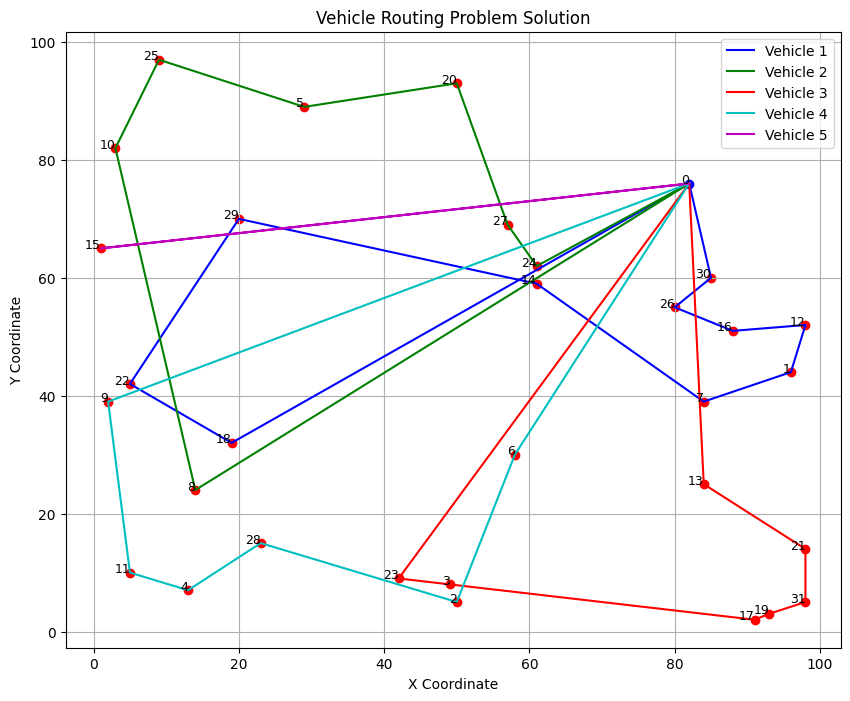

(True,
 1146.399631725379,
 [[0, 30, 26, 16, 12, 1, 7, 14, 29, 22, 18, 0],
  [0, 24, 27, 20, 5, 25, 10, 8, 0],
  [0, 13, 21, 31, 19, 17, 3, 23, 0],
  [0, 6, 2, 28, 4, 11, 9, 0],
  [0, 15, 0]])

In [25]:
import numpy as np
from dataclasses import dataclass
from typing import Tuple, List
import random
import math

class FunSearch:
    def run(self, func): return func
    def evolve(self, func): return func
funsearch = FunSearch()

@dataclass
class ConstructionContext:
    depot: int
    candidate: int
    distance: float
    demand: int
    vehicle_load: int
    vehicle_capacity: int
    locations: np.ndarray

@dataclass
class LocalSearchContext:
    route: Tuple[int, ...]
    candidate_nodes: Tuple[int, ...]
    distance_matrix: np.ndarray
    demand: np.ndarray
    capacity: int

def solve(data: dict) -> List[List[int]]:
    #两阶段求解框架
    # 阶段1：启发式初始解构建
    initial_routes = greedy_initial_solution(data)
    
    # 阶段2：进化局部优化
    optimized_routes = local_search_optimization(data, initial_routes)
    
    return optimized_routes

# ========== 初始解构建阶段 ==========
@funsearch.evolve
def construction_heuristic(ctx: ConstructionContext) -> float:
    #进化初始解构建策略（可调整权重)
    # part1: you should change and modify this function
    return (1 * ctx.distance )

def greedy_initial_solution(data: dict) -> List[List[int]]:
    #基于进化权重的启发式初始解生成
    routes = []
    unvisited = set(range(len(data['demand']))) - {data['depot']}
    
    while unvisited and len(routes) < data['num_vehicles']:
        route = [data['depot']]
        current_load = 0
        
        while True:
            candidates = [n for n in unvisited 
                         if data['demand'][n] + current_load <= data['vehicle_capacity']]
            if not candidates: break
            
            # 生成候选上下文
            contexts = [
                ConstructionContext(
                    depot=data['depot'],
                    candidate=n,
                    distance=data['distance_matrix'][route[-1]][n],
                    demand=data['demand'][n],
                    vehicle_load=current_load,
                    vehicle_capacity=data['vehicle_capacity'],
                    locations=data['locations']
                ) for n in candidates
            ]
            
            # 选择最优候选节点
            scores = [construction_heuristic(ctx) for ctx in contexts]
            next_node = candidates[np.argmin(scores)]
            
            route.append(next_node)
            current_load += data['demand'][next_node]
            unvisited.remove(next_node)
        
        if route[-1] != data['depot']:
            route.append(data['depot'])
        routes.append(route)
    
    return routes

# ========== 局部优化阶段 ==========
@funsearch.evolve
def local_search_optimization(data: dict, routes: list[list[int]]) -> list[list[int]]:
    optimized = []
    T = 1000  # 初始温度
    alpha = 0.99  # 降温系数
    min_T = 0.01  # 最小温度
    all_nodes = set(range(len(data['demand'])))
    all_nodes.remove(data['depot'])

    while True:
        temp_optimized = []
        for route in routes:
            if len(route) <= 2:
                temp_optimized.append(route)
                continue

            current_route = route.copy()
            current_cost = sum(data['distance_matrix'][i][j] for i, j in zip(current_route[:-1], current_route[1:]))

            while T > min_T:
                new_route = current_route.copy()
                # 随机选择 2-opt 或 3-opt 操作
                if random.random() < 0.5:
                    # 2-opt 操作
                    i = random.randint(1, len(current_route) - 2)
                    j = random.randint(i + 1, len(current_route) - 1)
                    new_route[i:j + 1] = reversed(new_route[i:j + 1])
                else:
                    # 3-opt 操作
                    segments = sorted(random.sample(range(1, len(current_route) - 1), 3))
                    a, b, c = segments
                    options = [
                        new_route[:a] + new_route[a:b][::-1] + new_route[b:c] + new_route[c:],
                        new_route[:a] + new_route[b:c] + new_route[a:b][::-1] + new_route[c:],
                        new_route[:a] + new_route[b:c][::-1] + new_route[a:b] + new_route[c:],
                        new_route[:a] + new_route[b:c][::-1] + new_route[a:b][::-1] + new_route[c:],
                        new_route[:a] + new_route[c:] + new_route[b:c][::-1] + new_route[a:b],
                        new_route[:a] + new_route[c:] + new_route[a:b] + new_route[b:c][::-1]
                    ]
                    best_option = min(options, key=lambda r: sum(data['distance_matrix'][i][j] for i, j in zip(r[:-1], r[1:])))
                    new_route = best_option

                # 确保新路径以仓库节点开始和结束
                new_route = [data['depot']] + new_route[1:-1] + [data['depot']]

                new_cost = sum(data['distance_matrix'][i][j] for i, j in zip(new_route[:-1], new_route[1:]))
                delta_cost = new_cost - current_cost

                if delta_cost < 0 or random.random() < math.exp(-delta_cost / T):
                    current_route = new_route
                    current_cost = new_cost

                T *= alpha

            temp_optimized.append(current_route)

        # 检查是否所有节点都被访问
        visited_nodes = set()
        for route in temp_optimized:
            for node in route:
                if node != data['depot']:
                    visited_nodes.add(node)

        if visited_nodes == all_nodes:
            optimized = temp_optimized
            break

    return optimized

@funsearch.run
def evaluate(data):
    routes = solve(data)
    total_distance = 0.0
    distance_matrix = data['distance_matrix']
    depot = data['depot']
    demand = data['demand']
    capacity = data['vehicle_capacity']
    all_nodes = set(range(len(demand)))
    all_nodes.remove(depot)

    # 评估解决方案并返回状态和总行驶距离
    try:
        visited_nodes = set()
        for i, route in enumerate(routes):
            if len(route) < 2 or route[0] != depot or route[-1] != depot:
                raise ValueError(f"Invalid route {i}: {route} - must start and end at depot")

            route_distance = 0.0
            route_demand = 0
            for j in range(len(route) - 1):
                from_node = route[j]
                to_node = route[j + 1]
                route_distance += distance_matrix[from_node][to_node]
                if to_node != depot:  # 仓库需求为0
                    route_demand += demand[to_node]
                    visited_nodes.add(to_node)

            if route_demand > capacity:
                raise ValueError(f"Route {i} overloaded: {route_demand}/{capacity}")

            total_distance += route_distance

        if visited_nodes != all_nodes:
            missing_nodes = all_nodes - visited_nodes
            raise ValueError(f"Not all nodes are visited. Missing nodes: {missing_nodes}")

        plot_CVRP_solution(routes, data['locations'])
        return True, total_distance, routes
    except ValueError as e:
        print(f"Evaluation failed: {e}")
        return False, "", []
    
# evaluate(data)
instances = read_all_instances('/Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small')
data = instances['A-n32-k5.vrp']
print(data)
evaluate(data)



In [26]:
import numpy as np
from dataclasses import dataclass
from typing import Tuple, List

class FunSearch:
    def run(self, func): return func
    def evolve(self, func): return func
funsearch = FunSearch()

@dataclass
class ConstructionContext:
    depot: int
    candidate: int
    distance: float
    demand: int
    vehicle_load: int
    vehicle_capacity: int
    locations: np.ndarray

@dataclass
class LocalSearchContext:
    route: Tuple[int, ...]
    candidate_nodes: Tuple[int, ...]
    distance_matrix: np.ndarray
    demand: np.ndarray
    capacity: int

def solve(data: dict) -> List[List[int]]:
    #两阶段求解框架
    # 阶段1：启发式初始解构建
    initial_routes = greedy_initial_solution(data)
    
    # 阶段2：进化局部优化
    optimized_routes = local_search_optimization(data, initial_routes)
    
    return optimized_routes

# ========== 初始解构建阶段 ==========
@funsearch.evolve
def construction_heuristic(ctx: ConstructionContext) -> float:
    #进化初始解构建策略（可调整权重)
    # part1: you should change and modify this function
    return (1 * ctx.distance )

def greedy_initial_solution(data: dict) -> List[List[int]]:
    #基于进化权重的启发式初始解生成
    routes = []
    unvisited = set(range(len(data['demand']))) - {data['depot']}
    
    while unvisited and len(routes) < data['num_vehicles']:
        # part2: you should change and modify this function
        route = [data['depot']]
        current_load = 0
        
        while True:
            candidates = [n for n in unvisited 
                         if data['demand'][n] + current_load <= data['vehicle_capacity']]
            if not candidates: break
            
            # 生成候选上下文
            contexts = [
                ConstructionContext(
                    depot=data['depot'],
                    candidate=n,
                    distance=data['distance_matrix'][route[-1]][n],
                    demand=data['demand'][n],
                    vehicle_load=current_load,
                    vehicle_capacity=data['vehicle_capacity'],
                    locations=data['locations']
                ) for n in candidates
            ]
            
            # 选择最优候选节点
            scores = [construction_heuristic(ctx) for ctx in contexts]
            next_node = candidates[np.argmin(scores)]
            
            route.append(next_node)
            current_load += data['demand'][next_node]
            unvisited.remove(next_node)
        
        route.append(data['depot'])
        routes.append(route)
    
    return routes

# ========== 局部优化阶段 ==========
@funsearch.evolve
def local_search_optimization(data: dict, routes: List[List[int]]) -> List[List[int]]:
    #基于进化策略的局部搜索
    optimized = []
    for route in routes:
        if len(route) <= 2:
            optimized.append(route)
            continue

        # 生成优化上下文
        ctx = LocalSearchContext(
            route=tuple(route),
            candidate_nodes=tuple(data['demand'].nonzero()[0]),
            distance_matrix=data['distance_matrix'],
            demand=data['demand'],
            capacity=data['vehicle_capacity']
        )

        # 应用进化优化策略
        while True:
            original_cost = sum(ctx.distance_matrix[i][j] for i, j in zip(ctx.route[:-1], ctx.route[1:]))
            best_improvement = 0.0
            best_route = route.copy()

            # 2-opt邻域评估
            for i in range(1, len(ctx.route) - 2):
                for j in range(i + 1, len(ctx.route) - 1):
                    new_cost = original_cost - ctx.distance_matrix[ctx.route[i - 1]][ctx.route[i]] \
                               - ctx.distance_matrix[ctx.route[j]][ctx.route[j + 1]] \
                               + ctx.distance_matrix[ctx.route[i - 1]][ctx.route[j]] \
                               + ctx.distance_matrix[ctx.route[i]][ctx.route[j + 1]]
                    improvement = original_cost - new_cost
                    if improvement > best_improvement:
                        best_improvement = improvement
                        new_route = list(ctx.route)
                        new_route[i:j + 1] = reversed(new_route[i:j + 1])
                        best_route = new_route

            if best_improvement <= 0:
                break
            route = best_route
            ctx.route = tuple(route)

        optimized.append(route)

    return optimized

@funsearch.run
def evaluate(data):
    routes = solve(data)
    total_distance = 0.0
    distance_matrix = data['distance_matrix']
    depot = data['depot']
    demand = data['demand']
    capacity = data['vehicle_capacity']
    
    #评估解决方案并返回状态和总行驶距离
    try:
        for i, route in enumerate(routes):
            if len(route) < 2 or route[0] != depot or route[-1] != depot:
                raise ValueError(f"Invalid route {i}: {route} - must start and end at depot")

            route_distance = 0.0
            route_demand = 0
            for j in range(len(route) - 1):
                from_node = route[j]
                to_node = route[j + 1]
                route_distance += distance_matrix[from_node][to_node]
                if to_node != depot:  # 仓库需求为0
                    route_demand += demand[to_node]

            if route_demand > capacity:
                raise ValueError(f"Route {i} overloaded: {route_demand}/{capacity}")

            total_distance += route_distance

        return True, total_distance,route
    except ValueError as e:
        print(f"Evaluation failed: {e}")
        return False , "",[]


In [32]:
import numpy as np
from dataclasses import dataclass
from typing import Tuple, List

class FunSearch:
    def run(self, func): return func
    def evolve(self, func): return func
funsearch = FunSearch()

@dataclass
class ConstructionContext:
    depot: int
    candidate: int
    distance: float
    demand: int
    vehicle_load: int
    vehicle_capacity: int
    locations: np.ndarray

@dataclass
class LocalSearchContext:
    route: Tuple[int, ...]
    candidate_nodes: Tuple[int, ...]
    distance_matrix: np.ndarray
    demand: np.ndarray
    capacity: int

def solve(data: dict) -> List[List[int]]:
    #两阶段求解框架
    # 阶段1：启发式初始解构建
    initial_routes = greedy_initial_solution(data)
    
    # 阶段2：进化局部优化
    optimized_routes = local_search_optimization(data, initial_routes)
    
    return optimized_routes

# ========== 初始解构建阶段 ==========
@funsearch.evolve
def construction_heuristic(ctx: ConstructionContext) -> float:
    #进化初始解构建策略（可调整权重)
    # part1: you should change and modify this function
    return (1 * ctx.distance )

def greedy_initial_solution(data: dict) -> List[List[int]]:
    #基于进化权重的启发式初始解生成
    routes = []
    unvisited = set(range(len(data['demand']))) - {data['depot']}
    
    while unvisited and len(routes) < data['num_vehicles']:
        # part2: you should change and modify this function
        route = [data['depot']]
        current_load = 0
        
        while True:
            candidates = [n for n in unvisited 
                         if data['demand'][n] + current_load <= data['vehicle_capacity']]
            if not candidates: break
            
            # 生成候选上下文
            contexts = [
                ConstructionContext(
                    depot=data['depot'],
                    candidate=n,
                    distance=data['distance_matrix'][route[-1]][n],
                    demand=data['demand'][n],
                    vehicle_load=current_load,
                    vehicle_capacity=data['vehicle_capacity'],
                    locations=data['locations']
                ) for n in candidates
            ]
            
            # 选择最优候选节点
            scores = [construction_heuristic(ctx) for ctx in contexts]
            next_node = candidates[np.argmin(scores)]
            
            route.append(next_node)
            current_load += data['demand'][next_node]
            unvisited.remove(next_node)
        
        route.append(data['depot'])
        routes.append(route)
    
    return routes

# ========== 局部优化阶段 ==========
@funsearch.evolve
def local_search_optimization(data: dict, routes: List[List[int]]) -> List[List[int]]:
    optimized = routes
    return optimized

@funsearch.run
def evaluate(data):
    routes = solve(data)
    total_distance = 0.0
    distance_matrix = data['distance_matrix']
    depot = data['depot']
    demand = data['demand']
    capacity = data['vehicle_capacity']
    
    #评估解决方案并返回状态和总行驶距离
    try:
        for i, route in enumerate(routes):
            if len(route) < 2 or route[0] != depot or route[-1] != depot:
                raise ValueError(f"Invalid route {i}: {route} - must start and end at depot")

            route_distance = 0.0
            route_demand = 0
            for j in range(len(route) - 1):
                from_node = route[j]
                to_node = route[j + 1]
                route_distance += distance_matrix[from_node][to_node]
                if to_node != depot:  # 仓库需求为0
                    route_demand += demand[to_node]

            if route_demand > capacity:
                raise ValueError(f"Route {i} overloaded: {route_demand}/{capacity}")

            total_distance += route_distance

        return True, total_distance,route
    except ValueError as e:
        print(f"Evaluation failed: {e}")
        return False , "",[]
# evaluate(data)
data = read_cvrp_data('/Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n32-k5.vrp')
print(data)
evaluate(data)


Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n32-k5.vrp
{'vehicle_capacity': 100, 'num_vehicles': 5, 'depot': 0, 'locations': [(82, 76), (96, 44), (50, 5), (49, 8), (13, 7), (29, 89), (58, 30), (84, 39), (14, 24), (2, 39), (3, 82), (5, 10), (98, 52), (84, 25), (61, 59), (1, 65), (88, 51), (91, 2), (19, 32), (93, 3), (50, 93), (98, 14), (5, 42), (42, 9), (61, 62), (9, 97), (80, 55), (57, 69), (23, 15), (20, 70), (85, 60), (98, 5)], 'num_locations': 32, 'demand': array([ 0, 19, 21,  6, 19,  7, 12, 16,  6, 16,  8, 14, 21, 16,  3, 22, 18,
       19,  1, 24,  8, 12,  4,  8, 24, 24,  2, 20, 15,  2, 14,  9]), 'distance_matrix': array([[  0.        ,  34.92849839,  77.87810989, ...,  62.28964601,
         16.2788206 ,  72.78049189],
       [ 34.92849839,   0.        ,  60.30754513, ...,  80.32434251,
         19.41648784,  39.05124838],
       [ 77.87810989,  60.30754513,   0.        , ...,  71.58910532,
         65.19202405,  48.        ],
      

(True, 1146.399631725379, [0, 15, 0])

In [ ]:
import numpy as np
from dataclasses import dataclass
from typing import List, Deque
from collections import deque
import random

class FunSearch:
    def run(self, func): return func
    def evolve(self, func): return func
funsearch = FunSearch()

@dataclass
class ConstructionContext:
    depot: int
    candidate: int
    distance: float
    demand: int
    vehicle_load: int
    vehicle_capacity: int
    locations: np.ndarray
    
def set_params():
    iterations = 100
    rate = 0.5
    return iterations,rate

def solve(data: dict) -> List[List[int]]:
    # 两阶段求解框架（LNS专用）
    initial_routes= savings_based_initial(data)  # 增强型初始解
    iterations, rate = set_params()
    
    optimized_routes = adaptive_lns(data, initial_routes, iterations,rate)
    return optimized_routes

# ========== 初始解构建 ==========
def savings_based_initial(data: dict) -> List[List[int]]:
    """使用节约法生成高质量初始解"""
    depot = data['depot']
    nodes = [i for i in range(len(data['demand'])) if i != depot]
    
    # 计算节约值
    savings = []
    for i in nodes:
        for j in nodes:
            if i != j:
                s = data['distance_matrix'][i][depot] + data['distance_matrix'][depot][j] - data['distance_matrix'][i][j]
                savings.append( (s, i, j) )
    
    # 按节约值降序排序
    savings.sort(reverse=True, key=lambda x: x[0])
    
    # 构建路径
    routes = []
    used = set()
    while len(used) < len(nodes):
        best = None
        for s in savings:
            i, j = s[1], s[2]
            if i in used or j in used:
                continue
                
            # 尝试新建路径
            new_route = [depot, i, j, depot]
            if get_route_demand(new_route, data) <= data['vehicle_capacity']:
                best = new_route
                used.update({i, j})
                break
                
        if best is None:
            # 处理剩余节点
            remaining = [n for n in nodes if n not in used]
            if remaining:
                route = [depot, remaining[0], depot]
                if get_route_demand(route, data) <= data['vehicle_capacity']:
                    routes.append(route)
                    used.add(remaining[0])
        else:
            routes.append(best)
    
    return routes

# ========== 大邻域搜索核心 ==========
def adaptive_lns(data, initial_routes, iterations=100,rate=0.5):
    current_routes = [r.copy() for r in initial_routes]
    current_cost = total_distance(current_routes, data)
    best_cost = current_cost
    best_routes = current_routes

    for iteration in range(iterations):
        # Destroy Phase
        partial_routes, removed_customers = destroy_solution(data,current_routes, rate)

        # Repair Phase
        repaired_routes = repair_solution(data, partial_routes, removed_customers)

        # Calculate the new cost of the repaired solution
        repaired_cost = sum(calculate_route_distance(route, data['distance_matrix']) for route in repaired_routes)

        # Comparision
        if repaired_cost < current_cost:
            current_routes = [route.copy() for route in repaired_routes]
            current_cost = repaired_cost

            if current_cost < best_cost:
                best_routes = [route.copy() for route in current_routes]
                best_cost = current_cost
    
    return best_routes

def destroy_solution(data,routes, destroy_rate):
    """增强型破坏策略"""
    all_nodes = [n for route in routes for n in route if n != routes[0][0]]
    to_remove = int(len(all_nodes) * destroy_rate)
    
    # 组合破坏方式：随机删除+关键节点删除
    removed_random = random.sample(all_nodes, int(to_remove*0.7))
    
    # 选择距离远的节点（概率性）
    depot = routes[0][0]
    distant_nodes = sorted(all_nodes, 
                         key=lambda x: np.linalg.norm(data['locations'][x][0]),
                         reverse=True)[:int(to_remove*0.3)]
    removed = list(set(removed_random + distant_nodes))[:to_remove]
    
    # 执行破坏
    new_routes = []
    for route in routes:
        new_route = [n for n in route if n not in removed and n != depot]
        if len(new_route) == 0:
            new_routes.append([depot, depot])
        else:
            new_routes.append([depot] + new_route + [depot])
    return new_routes, removed

def repair_solution(data, routes, removed_customers):
    demands = data['demand']
    vehicle_capacity = data['vehicle_capacity']
    distance_matrix = data['distance_matrix']
    num_vehicles = data['num_vehicles']
    depot = data['depot']
    for customer in removed_customers:
        best_insertion = None
        best_cost_increase = float('inf')
        best_route_idx = None

        for route_idx, route in enumerate(routes):
            # 去掉起始和结束的仓库节点进行插入操作
            inner_route = route[1:-1]
            route_demand = sum(demands[node] for node in inner_route)

            if route_demand + demands[customer] > vehicle_capacity:
                continue  # skip this route

            for i in range(len(inner_route) + 1):  # +1 you are allowed to insert the customer to the end
                new_inner_route = inner_route[:i] + [customer] + inner_route[i:]
                new_route = [depot] + new_inner_route + [depot]
                cost_increase = calculate_route_distance(new_route, distance_matrix) - calculate_route_distance(route,
                                                                                                                distance_matrix)
                if cost_increase < best_cost_increase:
                    best_cost_increase = cost_increase
                    best_insertion = new_route
                    best_route_idx = route_idx

        if best_insertion is not None:
            routes[best_route_idx] = best_insertion
        else:
            if len(routes) < num_vehicles:
                routes.append([depot, customer, depot])
            else:
                routes[0] = [depot] + [customer] + routes[0][1:-1] + [depot]

    return routes
# ========== 辅助函数 ==========
def get_route_demand(route, data):
    return sum(data['demand'][n] for n in route if n != data['depot'])

def total_distance(routes, data):
    return sum(calculate_route_distance(r, data['distance_matrix']) for r in routes)

def calculate_route_distance(route, distance_matrix):
    return sum(distance_matrix[route[i]][route[i+1]] for i in range(len(route)-1))

def validate_solution(data, routes):
    all_nodes = set(range(len(data['demand'])))
    covered = set(n for r in routes for n in r) - {data['depot']}
    if all_nodes != covered:
        print(f"Missing nodes: {all_nodes - covered}")
        return False
    
    for r in routes:
        if r[0] != data['depot'] or r[-1] != data['depot']:
            print(f"Invalid route endpoints: {r}")
            return False
        if get_route_demand(r, data) > data['vehicle_capacity']:
            print(f"Overloaded route: {r}")
            return False
    return True
# evaluate(data)
data = read_cvrp_data('/Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n32-k5.vrp')
print(data)
evaluate(data)

Successfully read /Users/antik/Desktop/cvrp-funsearch/cvrp-funsearch/cvrp/data/cvrp/small/A-n32-k5.vrp
{'vehicle_capacity': 100, 'num_vehicles': 5, 'depot': 0, 'locations': [(82, 76), (96, 44), (50, 5), (49, 8), (13, 7), (29, 89), (58, 30), (84, 39), (14, 24), (2, 39), (3, 82), (5, 10), (98, 52), (84, 25), (61, 59), (1, 65), (88, 51), (91, 2), (19, 32), (93, 3), (50, 93), (98, 14), (5, 42), (42, 9), (61, 62), (9, 97), (80, 55), (57, 69), (23, 15), (20, 70), (85, 60), (98, 5)], 'num_locations': 32, 'demand': array([ 0, 19, 21,  6, 19,  7, 12, 16,  6, 16,  8, 14, 21, 16,  3, 22, 18,
       19,  1, 24,  8, 12,  4,  8, 24, 24,  2, 20, 15,  2, 14,  9]), 'distance_matrix': array([[  0.        ,  34.92849839,  77.87810989, ...,  62.28964601,
         16.2788206 ,  72.78049189],
       [ 34.92849839,   0.        ,  60.30754513, ...,  80.32434251,
         19.41648784,  39.05124838],
       [ 77.87810989,  60.30754513,   0.        , ...,  71.58910532,
         65.19202405,  48.        ],
      

(True, 853.4556456739028, [0, 0])